In [1]:
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

from data.data_generators import *
import torch


def get_available_gpu_with_most_memory():
    gpu_memory = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch to the GPU to accurately measure memory
        gpu_memory.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
    
    gpu_memory.sort(key=lambda x: x[1], reverse=True)
    
    return gpu_memory[0][0]

if torch.cuda.is_available():
    available_gpu = get_available_gpu_with_most_memory()
    if available_gpu == 0:
        device_wta = torch.device("cuda:0")
        device_cnp = torch.device("cuda:0")
    else:
        device_wta = torch.device(f"cuda:{available_gpu}")
        device_cnp = torch.device(f"cuda:{available_gpu}")
else:
    device_wta = torch.device("cpu")
    device_cnp = torch.device("cpu")

print("Device WTA:", device_wta, "Device CNP:", device_cnp)

Device WTA: cuda:0 Device CNP: cuda:0


In [2]:
batch_size = 4
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 8
num_classes = 2
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 4
num_val_indiv = num_val//num_classes

colors = ['tomato', 'aqua', 'limegreen', 'gold']

num_inc = 0
num_exc = 0

fixed_obs_ratio = 0.00000

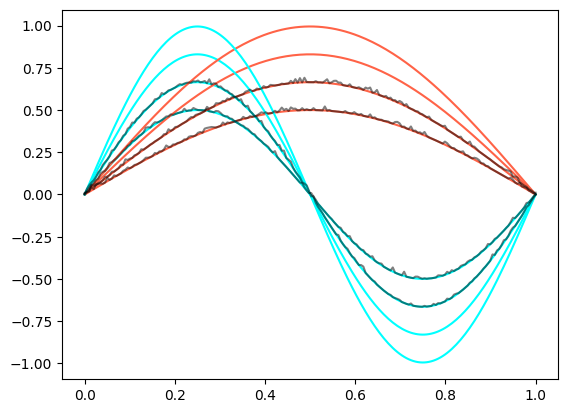

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_demos, 1).unsqueeze(-1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val, 1).unsqueeze(-1)
vy = torch.zeros(num_val, t_steps, dy)

y[0] = torch.unsqueeze(generate_sin(x[0]), 0) / 2.0
y[1] = torch.unsqueeze(generate_sin(x[0] * 2), 0) / 2.0

coef = 1
for i in range(num_indiv-1):
    coef += 0.33
    start_ind = (i+1) * num_classes
    y[start_ind] = y[0].clone() * coef
    y[start_ind+1] = y[1].clone() * coef
    
for i in range(num_val):
    noise = torch.unsqueeze(torch.clamp(torch.randn(x[0].shape)*1e-4**0.5, min=0) - noise_clip, 0)
    vy[i] = y[i].clone() + noise

from matplotlib import pyplot as plt

for i in range(num_indiv):
    plt.plot(x[i*num_classes, :, 0].cpu(), y[i*num_classes, :, 0].cpu(), colors[0%num_classes])
    plt.plot(x[i*num_classes+1, :, 0].cpu(), y[i*num_classes+1, :, 0].cpu(), colors[1%num_classes])

for i in range(num_val):
    plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)


x0, y0 = x.to(device_wta), y.to(device_wta)
x1, y1 = x.to(device_cnp), y.to(device_cnp)

In [4]:
def get_batch(x, y, traj_ids, device=device_wta):
    global num_inc, num_exc


    # if the following holds, we condition on 0, -1 or [0, -1] to estimate the rest
    # if not, we condition on random-numbered random points
    if torch.rand(1) < fixed_obs_ratio:
        num_inc += 1
        
        if torch.rand(1) < 0.33:
            n_o = 1  # [0]
            n_t = t_steps - 1
            o_ids = torch.tensor([0])
            t_ids = torch.randperm(t_steps-1)+1  # excluding [0]
        elif torch.rand(1) < 0.66:
            n_o = 1  # [-1]
            n_t = t_steps - 1
            o_ids = torch.tensor([-1])
            t_ids = torch.randperm(t_steps-1)  # excluding [-1]
        else:
            n_o = 2  # [0, -1]
            n_t = t_steps - 2
            o_ids = torch.tensor([0, -1])
            t_ids = torch.randperm(t_steps-2)+1  # excluding [0] and [-1]

        fixed = True
    
    else:
        num_exc += 1
        n_o = torch.randint(1, n_max_obs, (1,)).item()
        n_t = torch.randint(1, n_max_tar, (1,)).item()
        fixed = False

    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)
    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    
    for i in range(len(traj_ids)):
        if not fixed:
            random_query_ids = torch.randperm(t_steps) 
            
            o_ids = random_query_ids[:n_o]
            t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

def get_validation_batch(vx, vy, traj_ids, device=device_wta):
    num_obs = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:num_obs]

        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids], vy[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]

    return obs, tar, tar_val

In [5]:
model_wta = WTA_CNP(1, 1, n_max_obs, n_max_tar, [150, 150, 150], num_decoders=2, decoder_hidden_dims=[150, 150, 150], batch_size=batch_size, scale_coefs=True).to(device_wta)
optimizer_wta = torch.optim.Adam(lr=1e-4, params=model_wta.parameters())

model_cnp = CNP(input_dim=1, hidden_dim=185, output_dim=1, n_max_obs=n_max_obs, n_max_tar=n_max_tar, num_layers=3, batch_size=batch_size).to(device_cnp)
optimizer_cnp = torch.optim.Adam(lr=1e-4, params=model_cnp.parameters())

# print("WTA Model:", model_wta)

In [6]:
def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("WTA-CNP:", get_parameter_count(model_wta))
print("CNP:", get_parameter_count(model_cnp))

WTA-CNP: 137556
CNP: 138752


In [7]:
from matplotlib.lines import Line2D


def draw_val_plot(root_folder, epoch):
    plt_y_lim = torch.max(vy) + 0.1

    obs = torch.zeros((batch_size, 1, 1, 2)).to(device_wta)
    for i in range(batch_size):
        obs[i] = torch.Tensor([x[i, 80, 0], y[i, 80, 0]]).unsqueeze(0).unsqueeze(0).to(device_wta)

    tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).to(device_wta)

    with torch.no_grad():
        for i in range(batch_size):
            pred_cnp, _ = model_cnp(obs[i], tar)
            pred_wta, gate = model_wta(obs[i], tar)
            print(pred_wta.shape)

            plt.ylim((-plt_y_lim, plt_y_lim))
            plt.scatter(obs[i,:,:,0].cpu(), obs[i,:,:,1].cpu(), c='k')
            for j in range(model_wta.num_decoders):
                plt.plot(torch.linspace(0, 1, 200), pred_wta[j,i,:,0].cpu(), colors[j], alpha=max(0.2, gate[0, 0, j].item()))  # wta pred
            plt.plot(torch.linspace(0, 1, 200), pred_cnp[:, :, :model_cnp.output_dim].squeeze(0).cpu(), 'b')  # cnp pred
            handles = []
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), vy[j].squeeze(-1).cpu(), 'k', alpha=0.05 if j!=i else 0.35)  # data
                handles.append(Line2D([0], [0], label=f'gate{j}: {gate[0, 0, j].item():.4f}', color=colors[j]))

            plt.legend(handles=handles, loc='upper right')

            plt.savefig(f'{root_folder}img/{i}_{epoch}.png')
            plt.close()

In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/sines/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 750_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_wta, avg_loss_cnp = 0, 0

val_per_epoch = 1000
min_val_loss_wta, min_val_loss_cnp = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

training_loss_wta, validation_error_wta = torch.zeros(epochs), torch.zeros(epochs//val_per_epoch)
training_loss_cnp, validation_error_cnp = torch.zeros(epochs), torch.zeros(epochs//val_per_epoch)

wta_tr_loss_path = f'{root_folder}wta_training_loss.pt'
wta_val_err_path = f'{root_folder}wta_validation_error.pt'
cnp_tr_loss_path = f'{root_folder}cnp_training_loss.pt'
cnp_val_err_path = f'{root_folder}cnp_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_wta, epoch_loss_cnp = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer_wta.zero_grad()
        optimizer_cnp.zero_grad()

        obs_wta, tar_x_wta, tar_y_wta = get_batch(x, y, traj_ids[i], device_wta)
        obs_cnp, tar_x_cnp, tar_y_cnp = obs_wta.clone(), tar_x_wta.clone(), tar_y_wta.clone()

        pred_wta, gate_wta = model_wta(obs_wta, tar_x_wta)
        pred_cnp, encoded_rep_cnp = model_cnp(obs_cnp, tar_x_cnp)

        loss_wta, wta_nll = model_wta.loss(pred_wta, gate_wta, tar_y_wta)

        loss_wta.backward()
        optimizer_wta.step()

        loss_cnp = model_cnp.loss(pred_cnp, tar_y_cnp)
        loss_cnp.backward()
        optimizer_cnp.step()

        epoch_loss_wta += wta_nll.item()
        epoch_loss_cnp += loss_cnp.item()

    training_loss_wta[epoch] = epoch_loss_wta
    training_loss_cnp[epoch] = epoch_loss_cnp

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss_wta, val_loss_cnp = 0, 0

            for j in range(v_epoch_iter):
                o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j], device=device_wta)
                o_cnp, t_cnp, tr_cnp = o_wta.clone(), t_wta.clone(), tr_wta.clone()

                p_wta, g_wta = model_wta(o_wta, t_wta)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss_wta += mse_loss(vp_means, tr_wta).item()

                pred_cnp, encoded_rep = model_cnp(o_cnp, t_cnp)
                val_loss_cnp += mse_loss(pred_cnp[:, :, :model_cnp.output_dim], tr_cnp)

            validation_error_wta[epoch//val_per_epoch] = val_loss_wta
            if val_loss_wta < min_val_loss_wta:
                min_val_loss_wta = val_loss_wta
                print(f'(WTA)New best: {min_val_loss_wta}')
                torch.save(model_wta.state_dict(), f'{root_folder}saved_models/wta_on_synth.pt')

            validation_error_cnp[epoch//val_per_epoch] = val_loss_cnp.item()
            if val_loss_cnp < min_val_loss_cnp:
                min_val_loss_cnp = val_loss_cnp
                print(f'(CNP)New best: {min_val_loss_cnp}')
                torch.save(model_cnp.state_dict(), f'{root_folder}saved_models/cnp_on_synth.pt')
  
#         if epoch % (val_per_epoch*10) == 0:
#             draw_val_plot(root_folder, epoch)

    avg_loss_wta += epoch_loss_wta
    avg_loss_cnp += epoch_loss_cnp

    if epoch % 100 == 0:
        print("Epoch: {}, WTA-Loss: {}, CNP-Loss: {}".format(epoch, avg_loss_wta/100, avg_loss_cnp/100))
        avg_loss_wta, avg_loss_cnp = 0, 0

    if epoch % 100000:
        torch.save(torch.Tensor(training_loss_wta), wta_tr_loss_path)
        torch.save(torch.Tensor(validation_error_wta), wta_val_err_path)
        torch.save(torch.Tensor(training_loss_cnp), cnp_tr_loss_path)
        torch.save(torch.Tensor(validation_error_cnp), cnp_val_err_path)

(WTA)New best: 0.17378897964954376
(CNP)New best: 0.2140238881111145
Epoch: 0, WTA-Loss: 0.017484135627746582, CNP-Loss: 0.01847830891609192
Epoch: 100, WTA-Loss: 1.348252248764038, CNP-Loss: 1.3424651750922203
Epoch: 200, WTA-Loss: 1.078106442913413, CNP-Loss: 1.046097177118063
Epoch: 300, WTA-Loss: 0.9964902641624213, CNP-Loss: 0.9532230109721422
Epoch: 400, WTA-Loss: 0.8689518526941538, CNP-Loss: 0.842393858123105
Epoch: 500, WTA-Loss: 0.7570463339611888, CNP-Loss: 0.6670409110886976
Epoch: 600, WTA-Loss: 0.7206782315671444, CNP-Loss: 0.6154292387398891
Epoch: 700, WTA-Loss: 0.6365372474491596, CNP-Loss: 0.5082841284479946
Epoch: 800, WTA-Loss: 0.5898053621500731, CNP-Loss: 0.4134625061735278
Epoch: 900, WTA-Loss: 0.5613931864872574, CNP-Loss: 0.38539678922621534
(WTA)New best: 0.054116446524858475
(CNP)New best: 0.039673980325460434
Epoch: 1000, WTA-Loss: 0.5333923522476107, CNP-Loss: 0.3393871740740724
Epoch: 1100, WTA-Loss: 0.5057498643733561, CNP-Loss: 0.20205396133707837
Epoch:

In [9]:
# get_batch(x, y, torch.tensor([0]))
#o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j])
#print(o_wta[0].shape)

In [10]:
# from PIL import Image
# import glob

# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
#     frame_one = frames[0]
#     frame_one.save(f'{root_folder}img/animated.gif', format="GIF", append_images=frames,
#                save_all=True, duration=1000, loop=0)
    
# make_gif(f'{root_folder}img/')

In [11]:

# print(y)

In [12]:
print(f'num_inc / num_all: {num_inc}/{num_inc+num_exc}')

num_inc / num_all: 0/1500000
